# Использование ежедневных обменных курсов валют для предсказания ВВП и ИПЦ

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import warnings
import datetime

import statsmodels.api as sm
from statsmodels.tsa.x13 import x13_arima_analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.stats as sm_stat
import statsmodels.tsa as smt
import scipy.optimize as optimize
import statsmodels.formula.api as smf
from statsmodels.tsa.api import ARDL
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ardl import ardl_select_order

from itertools import product

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


from midas.mix import mix_freq, mix_freq2
from midas.adl import estimate, forecast, midas_adl, rmse, estimate2,forecast2, midas_adl2

In [2]:
ex_rates = pd.read_csv('ex_rates_2024.csv', parse_dates=['Date'], dayfirst=False, index_col='Date', sep=',')['2016-07-01':'2023-12-31']
ex_rates.tail()

,RUB,EUR,USD
Date,,,
2023-12-27,3.4820,3.5204,3.1962
2023-12-28,3.4831,3.5319,3.1953
2023-12-29,3.4991,3.5363,3.1775
2023-12-30,3.4991,3.5363,3.1775
2023-12-31,3.4991,3.5363,3.1775


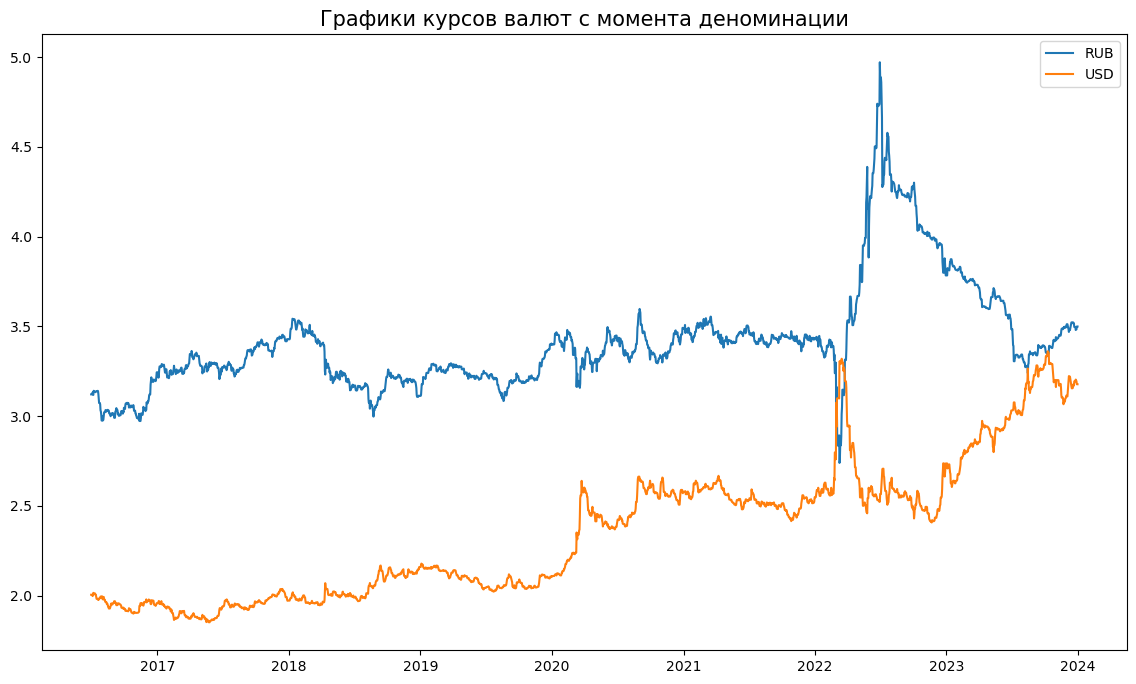

In [112]:
plt.figure(figsize=(14, 8))
plt.plot(ex_rates.RUB)
plt.plot(ex_rates.USD)
plt.title('Графики курсов валют с момента деноминации', fontsize=15)
plt.legend(('RUB', 'USD'))
None

In [3]:
usd = adfuller(ex_rates['USD'])
rur = adfuller(ex_rates['RUB'])

DF_test = pd.DataFrame([[usd[0], rur[0]], [usd[1], rur[1]]], index=["ADF Statistic", "p-value:"], columns=["USD", "RUB"]).T
DF_test

,ADF Statistic,p-value:
USD,-0.653813,0.858353
RUB,-2.396551,0.142712


In [4]:
growth_ex_rates = (ex_rates / ex_rates.shift()).dropna().rename(columns={'RUB' : 'GRUB', 'USD' : 'GUSD', 'EUR' : 'GEUR'})
growth_ex_rates.tail()

,GRUB,GEUR,GUSD
Date,,,
2023-12-27,1.000661,0.998553,0.997690
2023-12-28,1.000316,1.003267,0.999718
2023-12-29,1.004594,1.001246,0.994429
2023-12-30,1.000000,1.000000,1.000000
2023-12-31,1.000000,1.000000,1.000000


In [5]:
log_growth_ex_rates = np.log(growth_ex_rates)
log_growth_ex_rates.tail()

,GRUB,GEUR,GUSD
Date,,,
2023-12-27,0.000661,-0.001448,-0.002313
2023-12-28,0.000316,0.003261,-0.000282
2023-12-29,0.004583,0.001245,-0.005586
2023-12-30,0.000000,0.000000,0.000000
2023-12-31,0.000000,0.000000,0.000000


In [6]:
#log_growth_ex_rates.to_csv('C:/Users/bzzdwn/Documents/Mathematical-Modeling-And-Data-Analysis/data/ex_rates_dd.csv')

In [7]:
usd = adfuller(growth_ex_rates['GUSD'])
rur = adfuller(growth_ex_rates['GRUB'])

DF_test = pd.DataFrame([[usd[0], rur[0]], [usd[1], rur[1]]], index=["ADF Statistic", "p-value:"], columns=["GUSD", "GRUB"]).T
DF_test

,ADF Statistic,p-value:
GUSD,-13.789392,8.985260e-26
GRUB,-10.677356,4.021868e-19


In [8]:
# измерить на темпах роста x_t = x_t / x_{t-1} 
# также попробовать прологарифмировать ln(x_t)-ln(x_t-1)
# попробовать break point unit root ADF

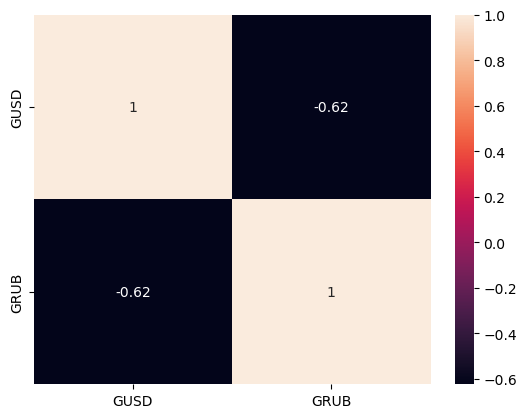

In [9]:
sns.heatmap(growth_ex_rates[['GUSD', 'GRUB']].corr(), annot = True)
None

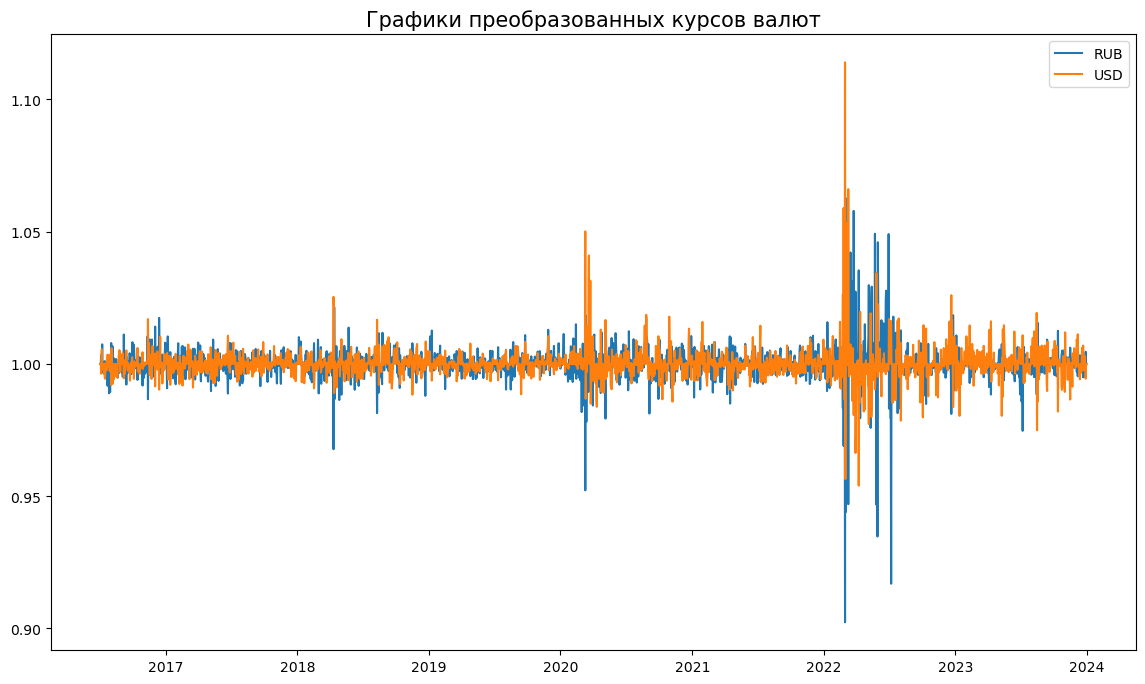

In [113]:
plt.figure(figsize=(14, 8))
plt.plot(growth_ex_rates.GRUB)
plt.plot(growth_ex_rates.GUSD)
plt.title('Графики преобразованных курсов валют', fontsize=15)
plt.legend(('RUB', 'USD'))
None

In [10]:
cpi_mm = pd.read_csv('cpi_mm_2023.csv', parse_dates=['Date'], dayfirst=True, index_col='Date', sep=',')
cpi_mm.tail()

,CPI_MM
Date,
2023-08-01,100.3874
2023-09-01,100.5203
2023-10-01,100.5128
2023-11-01,100.6500
2023-12-01,100.8700


In [127]:
cpi_qq = pd.read_csv('cpi_qq_2023.csv', parse_dates=['Date'], dayfirst=True, index_col='Date', sep=',')
cpi_qq.tail()

,CPI_QQ
Date,
2022-10-01,98.5111
2023-01-01,101.3595
2023-04-01,100.4762
2023-07-01,100.5203
2023-10-01,100.8700


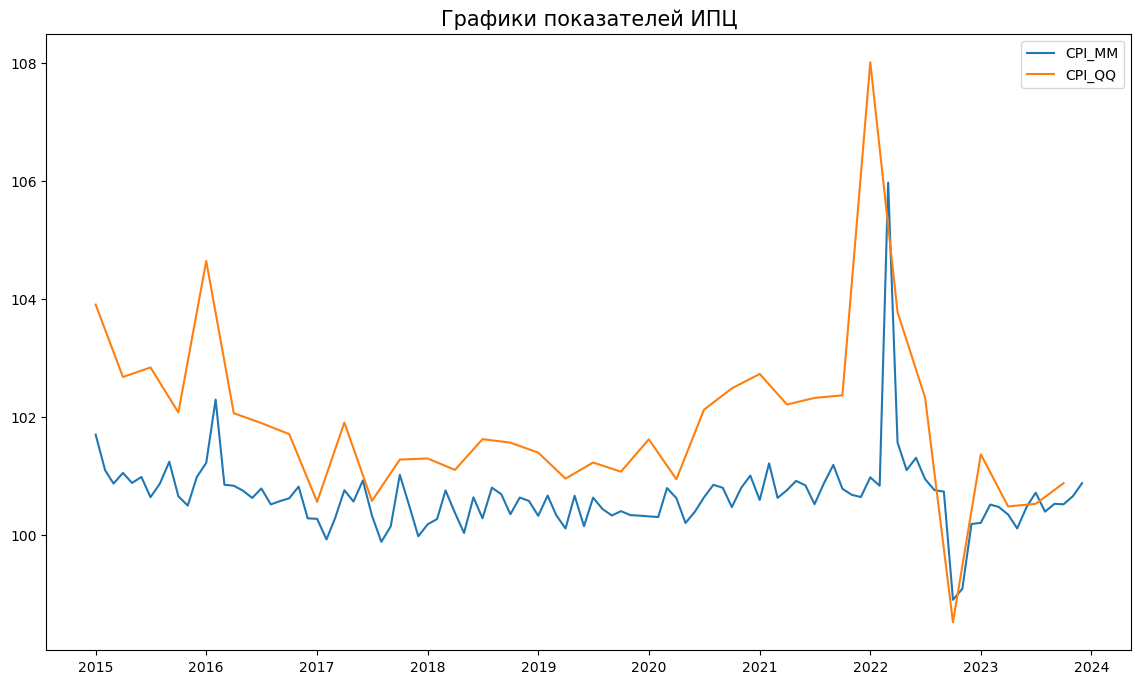

In [125]:
plt.figure(figsize=(14, 8))
plt.plot(cpi_mm['2015-01-01':])
plt.plot(cpi_qq)
plt.title('Графики показателей ИПЦ', fontsize=15)
plt.legend(('CPI_MM', 'CPI_QQ'))
None

In [12]:
DF_test = pd.DataFrame([[usd[0], rur[0], adfuller(cpi_mm)[0], adfuller(cpi_qq)[0]], 
                        [usd[1], rur[1], adfuller(cpi_mm)[1], adfuller(cpi_qq)[1]]], 
                       index=["ADF Statistic", "p-value:"], 
                       columns=["GUSD", "GRUB", "CPI_MM", "CPI_QQ"]).T
DF_test

,ADF Statistic,p-value:
GUSD,-13.789392,8.985260e-26
GRUB,-10.677356,4.021868e-19
CPI_MM,-4.834745,4.664619e-05
CPI_QQ,-4.031031,1.256461e-03


In [13]:
gdp = pd.read_csv('gdp_data_2023.csv', parse_dates=['Date'], dayfirst=True, date_format='%Y-%m-%d', index_col='Date', sep=',').dropna()['2003-01-01':]
gdp.tail()

,RB_GDP,RU_GDP
Date,,
2022-10-01,31326.6,25913.38
2023-01-01,28416.4,20830.36
2023-04-01,29923.5,22651.04
2023-07-01,33873.7,24355.82
2023-10-01,32843.1,26717.60


In [15]:
#cpi_mm.to_csv('C:/Users/bzzdwn/Documents/Mathematical-Modeling-And-Data-Analysis/data/cpi_mm.csv')
#cpi_qq.to_csv('C:/Users/bzzdwn/Documents/Mathematical-Modeling-And-Data-Analysis/data/cpi_qq.csv')

In [14]:
import os
os.chdir(r'C:\Users\bzzdwn\Downloads\x13as_ascii-v1-1-b60\x13as')

In [15]:
x13_analysis_gdp_rb = x13_arima_analysis(gdp.RB_GDP)
print(x13_analysis_gdp_rb.stdout.decode("utf-8"))


 X-13ARIMA-SEATS Seasonal Adjustment Program
 Version Number 1.1 Build 60
 Execution began  May 16, 2024  23.56.39 

  Reading input spec file from C:\Users\bzzdwn\AppData\Local\Temp\tmp8gm4smph.spc
  Storing any program output into C:\Users\bzzdwn\AppData\Local\Temp\tmpwv2fjook.out
  Storing any program error messages into C:\Users\bzzdwn\AppData\Local\Temp\tmpwv2fjook.err
 

 Execution complete for C:\Users\bzzdwn\AppData\Local\Temp\tmp8gm4smph.spc at  May 16, 2024  23.56.39 
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL



In [16]:
x13_analysis_gdp_ru = x13_arima_analysis(gdp.RU_GDP)
print(x13_analysis_gdp_ru.stdout.decode("utf-8"))


 X-13ARIMA-SEATS Seasonal Adjustment Program
 Version Number 1.1 Build 60
 Execution began  May 16, 2024  23.56.39 

  Reading input spec file from C:\Users\bzzdwn\AppData\Local\Temp\tmp5d96fge0.spc
  Storing any program output into C:\Users\bzzdwn\AppData\Local\Temp\tmp9zcb308r.out
  Storing any program error messages into C:\Users\bzzdwn\AppData\Local\Temp\tmp9zcb308r.err
 

 Execution complete for C:\Users\bzzdwn\AppData\Local\Temp\tmp5d96fge0.spc at  May 16, 2024  23.56.39 
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL



In [17]:
gdp_rb_sa = pd.DataFrame(x13_analysis_gdp_rb.seasadj).rename(columns={'seasadj' : 'GDP_RB_SA'})
gdp_ru_sa = pd.DataFrame(x13_analysis_gdp_ru.seasadj).rename(columns={'seasadj' : 'GDP_RU_SA'})

In [18]:
ggdp_rb_sa = np.log(gdp_rb_sa / gdp_rb_sa.shift()).dropna().rename(columns={'GDP_RB_SA' : 'GGDP_RB_SA'})
ggdp_ru_sa = np.log(gdp_ru_sa / gdp_ru_sa.shift()).dropna().rename(columns={'GDP_RU_SA' : 'GGDP_RU_SA'})

In [20]:
DF_test = pd.DataFrame([[usd[0], rur[0], adfuller(cpi_mm)[0], adfuller(cpi_qq)[0], adfuller(ggdp_rb_sa)[0], adfuller(ggdp_ru_sa)[0]], 
                        [usd[1], rur[1], adfuller(cpi_mm)[1], adfuller(cpi_qq)[1], adfuller(ggdp_rb_sa)[1], adfuller(ggdp_ru_sa)[1]]], 
                       index=["ADF Statistic", "p-value:"], 
                       columns=["GUSD", "GRUB", "CPI_MM", "CPI_QQ", "GGDP_RB_SA", "GGDP_RU_SA"]).T
DF_test

,ADF Statistic,p-value:
GUSD,-13.789392,8.985260e-26
GRUB,-10.677356,4.021868e-19
CPI_MM,-4.834745,4.664619e-05
CPI_QQ,-4.031031,1.256461e-03
GGDP_RB_SA,-6.825192,1.955999e-09
GGDP_RU_SA,-7.771628,8.889318e-12


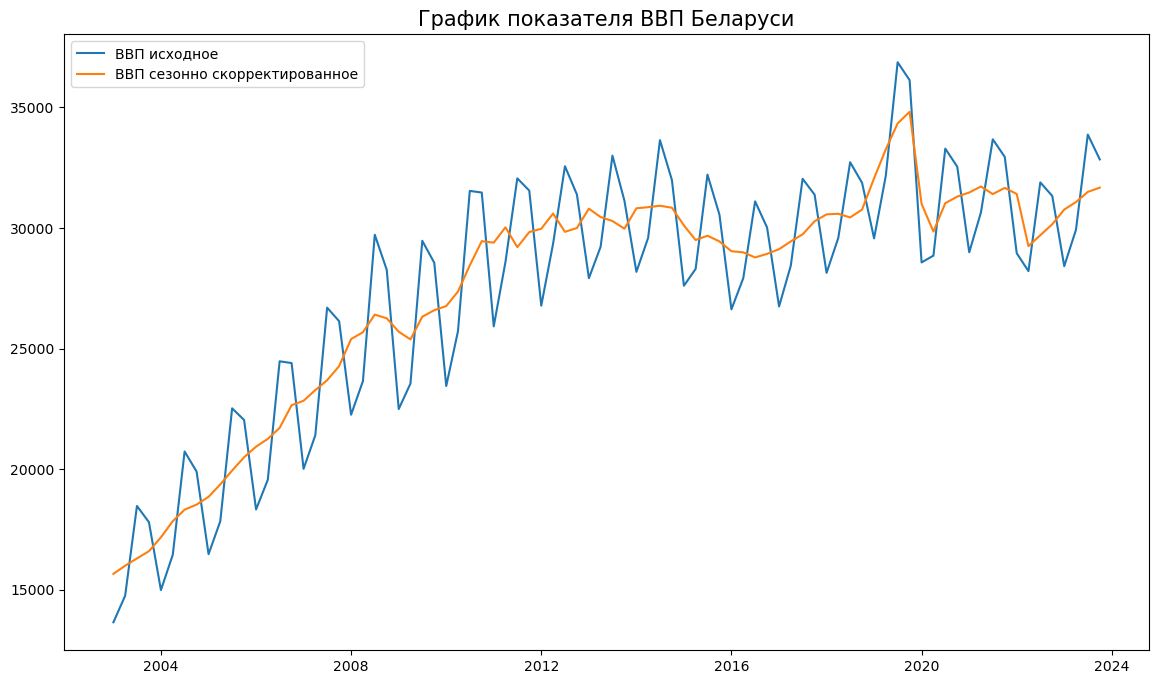

In [129]:
plt.figure(figsize=(14, 8))
plt.plot(pd.concat([gdp.RB_GDP, gdp_rb_sa], axis=1))
plt.title('График показателя ВВП Беларуси', fontsize=15)
plt.legend(('ВВП исходное', 'ВВП сезонно скорректированное'))
None

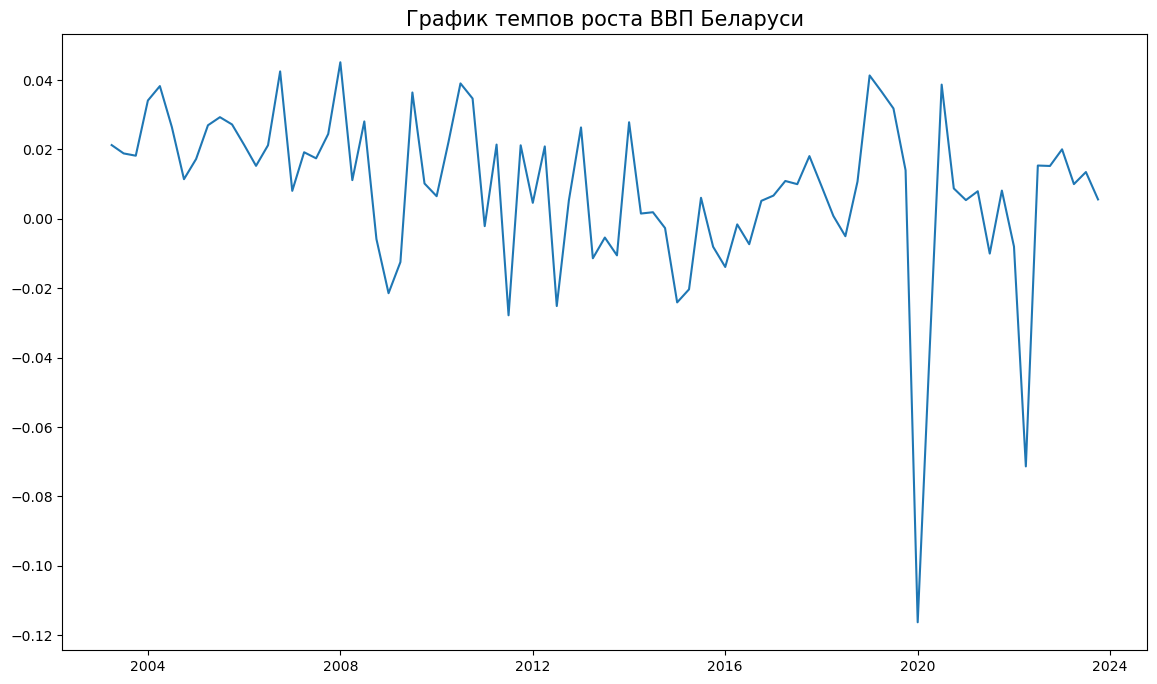

In [131]:
plt.figure(figsize=(14, 8))
plt.plot(ggdp_rb_sa)
plt.title('График темпов роста ВВП Беларуси', fontsize=15)
None

In [39]:
#ggdp_rb_sa.to_csv('C:/Users/bzzdwn/Documents/Mathematical-Modeling-And-Data-Analysis/data/ggdp_qq.csv')

1) сделать GDP_SA стационарными, MIDAS только со стац
2) GGDP RB = GDP RB / GDP RB(-1) (Growth gdp, т.е темпы роста). Протестировать на стационарные, он может оказаться не стационарным (проверить DF со структ изм.)

задаются лаги Lmax, Lprior. напр. Lmax=20, Lmin=5,6. проверяет стат значимость.
попробовать использовать leads (будущие значения в квартале). 

добавить тесты сезонности. 
Census x13, x12...
Tramo/Seat (иногда не срабатывает)
после обнарудения сезноонси BPUR

# 1) построение и оптимизация квартальных моделей MIDAS по смешанным данным для реального ВВП РБ:

- эндогенные переменные: сезонно скорректированные реальный ВВП РБ и объем промышленной продукции  (квартальные временные ряды),

- экзогенные месячные переменные: $x_1$ = индекс цен производителей продукции (PPI для РБ);

- экзогенные ежедневные переменные: $x_2$ = обменные курсы белорусского рубля по отношению к российскому рублю и доллару.

## $Lag(x_1)=89$, $Lag(x_2)=1$, $\beta$-lags

In [28]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [282]:
models_predictions_statistics = pd.DataFrame(None, columns=['MAE', 'MAPE', 'RMSE'])
models_forecast_statistics = pd.DataFrame(None, columns=['MAE', 'MAPE', 'RMSE'])

In [291]:
models_predictions_statistics

,MAE,MAPE,RMSE
MIDAS CPI_MM+RUB ExpAlmon,0.013467,0.993322,0.017887
DL CPI_QQ,0.016318,1.001932,0.023231
ARDL CPI_QQ,0.012386,1.122417,0.015147


In [270]:
models_forecast_statistics

,MAE,MAPE,RMSE
MIDAS CPI_MM Beta,0.004407,0.787724,0.004407
MIDAS CPI_MM ExpAlmon,0.004407,0.787740,0.004407
MIDAS CPI_MM+RUB Beta,0.001626,0.290612,0.006263
MIDAS CPI_MM+RUB ExpAlmon,0.001587,0.283747,0.006301
MIDAS CPI_MM+USD Beta,0.004614,0.824704,0.012502
MIDAS CPI_MM+USD ExpAlmon,0.002240,0.400436,0.005648


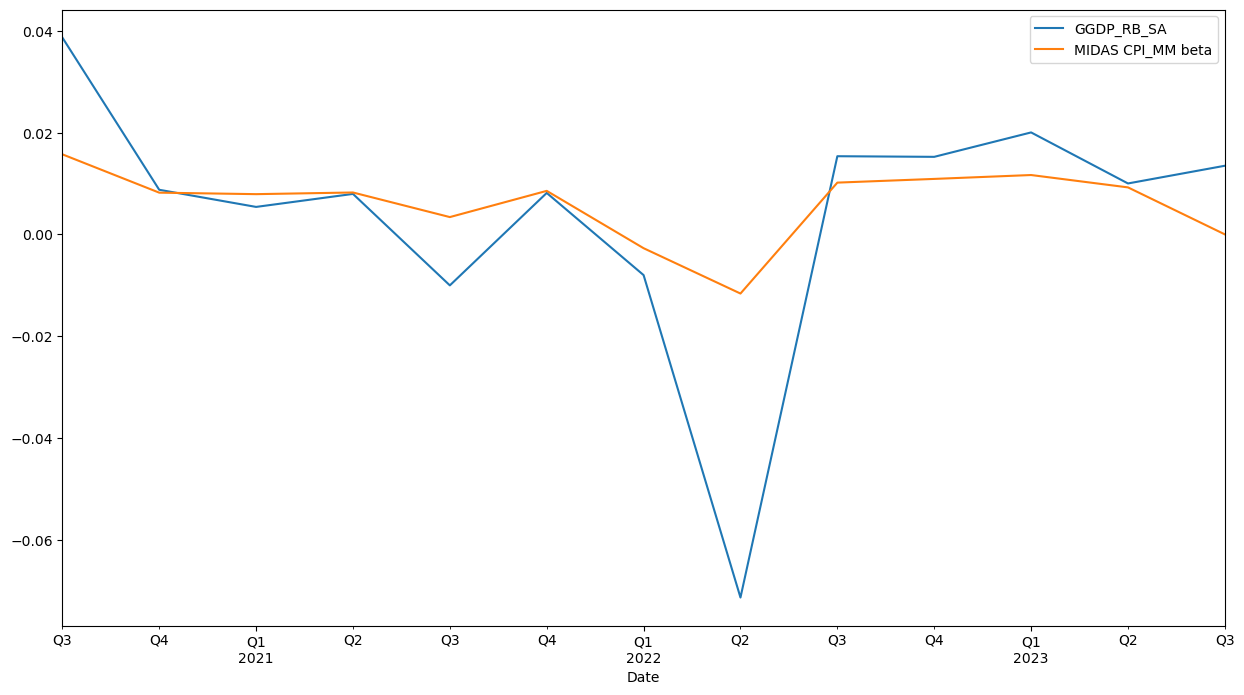

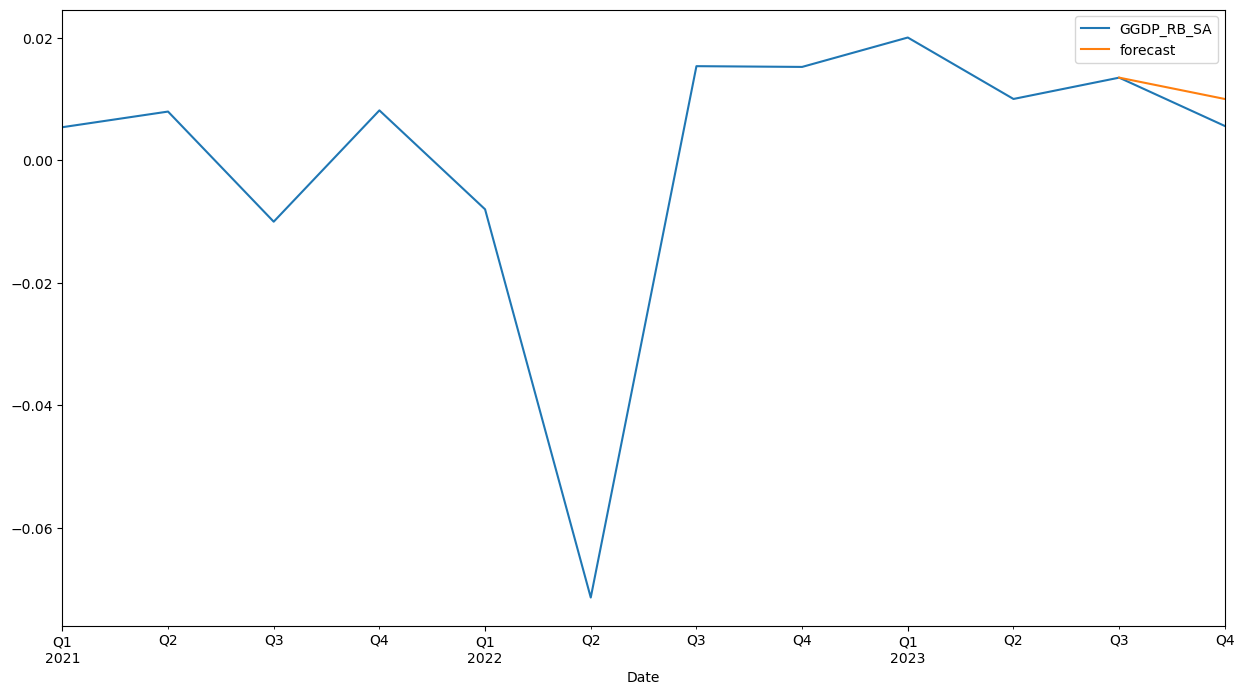

In [263]:
y, yl, x, yf, ylf, xf = mix_freq(lf_data=ggdp_rb_sa.GGDP_RB_SA, 
                                 hf_data=cpi_mm.CPI_MM, 
                                 xlag=12,  
                                 ylag=1, 
                                 horizon=1,
                                 start_date=datetime.datetime(2003,1,1),
                                 end_date=datetime.datetime(2023,7,1))
model_6 = estimate(y, yl, x, poly='beta')

fc1 = forecast(x, yl, model_6, poly='beta')
forecast1_df = fc1.join(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01']).shift(-1).fillna(0)
forecast1_df['residuals'] = forecast1_df.yfh - forecast1_df.GGDP_RB_SA

models_predictions_statistics.loc['MIDAS CPI_MM Beta'] = [
    mean_absolute_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']),
    mean_absolute_percentage_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']),
    np.sqrt(mean_squared_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']))]

models_results = pd.DataFrame(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'])
models_results = pd.concat([models_results, forecast1_df.yfh.loc['2020-07-01':'2023-07-01']], axis=1).rename(columns={'yfh' : 'MIDAS CPI_MM beta'})

models_results.plot(figsize=(15,8), style=['-', '-'])

fc = forecast(xf, ylf, model_6, poly='beta')
forecast_df = fc.join(yf)
forecast_df['residuals'] = forecast_df.yfh - forecast_df.GGDP_RB_SA

forecasting = ggdp_rb_sa.tail(2).head(1)
forecasting = forecasting.join(forecast_df.yfh, how='outer')
forecasting.iloc[0, 1] = forecasting.iloc[0, 0]
forecasting=forecasting.drop(columns=['GGDP_RB_SA']).rename(columns={'yfh':'forecast'})

models_forecast_statistics.loc['MIDAS CPI_MM Beta'] = [
    mean_absolute_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh),
    mean_absolute_percentage_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh),
    np.sqrt(mean_squared_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh))]

df_gdp = pd.concat([ggdp_rb_sa.GGDP_RB_SA['2021-01-01':'2023-10-01'], 
                    forecasting, ], axis=1)
df_gdp.plot(figsize=(15,8), style=['-', '-'])
None

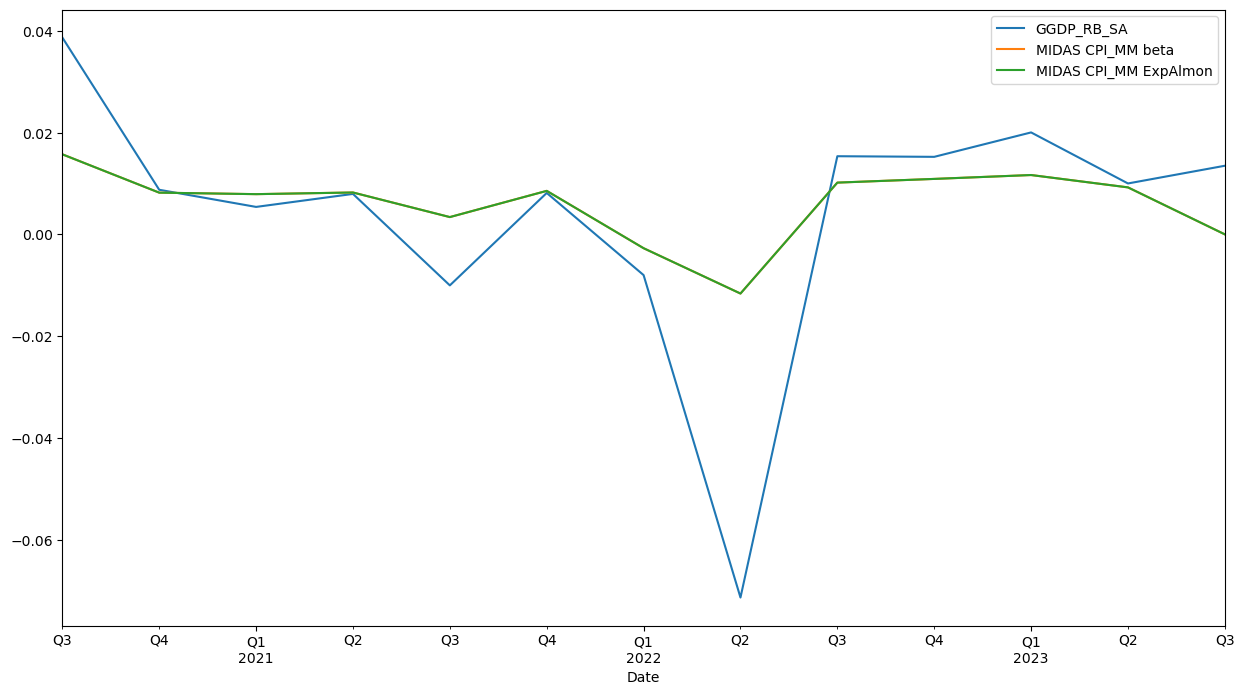

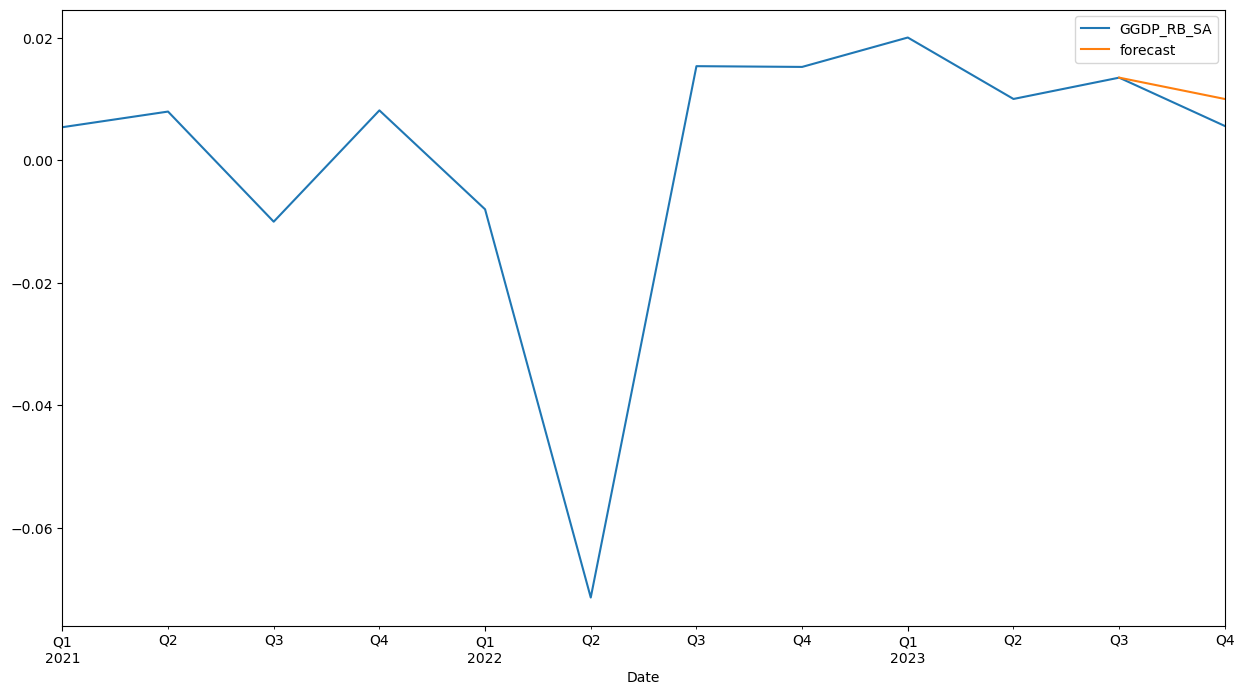

In [264]:
model_7 = estimate(y, yl, x, poly='expalmon')

fc1 = forecast(x, yl, model_7, poly='expalmon')
forecast1_df = fc1.join(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01']).shift(-1).fillna(0)
forecast1_df['residuals'] = forecast1_df.yfh - forecast1_df.GGDP_RB_SA

models_predictions_statistics.loc['MIDAS CPI_MM ExpAlmon'] = [
    mean_absolute_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']),
    mean_absolute_percentage_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']),
    np.sqrt(mean_squared_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']))]

models_results = pd.concat([models_results, forecast1_df.yfh.loc['2020-07-01':'2023-07-01']], axis=1).rename(columns={'yfh' : 'MIDAS CPI_MM ExpAlmon'})

models_results.plot(figsize=(15,8), style=['-', '-'])

fc = forecast(xf, ylf, model_7, poly='expalmon')
forecast_df = fc.join(yf)
forecast_df['residuals'] = forecast_df.yfh - forecast_df.GGDP_RB_SA

forecasting = ggdp_rb_sa.tail(2).head(1)
forecasting = forecasting.join(forecast_df.yfh, how='outer')
forecasting.iloc[0, 1] = forecasting.iloc[0, 0]
forecasting=forecasting.drop(columns=['GGDP_RB_SA']).rename(columns={'yfh':'forecast'})

models_forecast_statistics.loc['MIDAS CPI_MM ExpAlmon'] = [
    mean_absolute_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh),
    mean_absolute_percentage_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh),
    np.sqrt(mean_squared_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh))]

df_gdp = pd.concat([ggdp_rb_sa.GGDP_RB_SA['2021-01-01':'2023-10-01'], 
                    forecasting, ], axis=1)
df_gdp.plot(figsize=(15,8), style=['-', '-'])
None

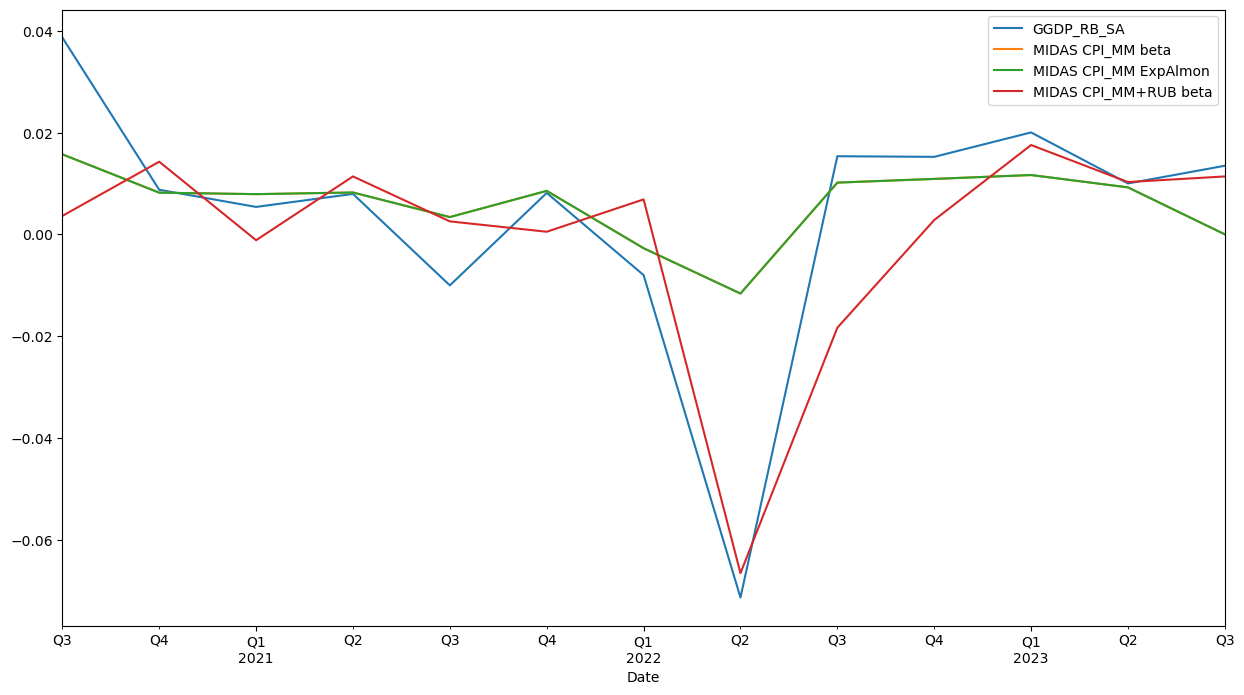

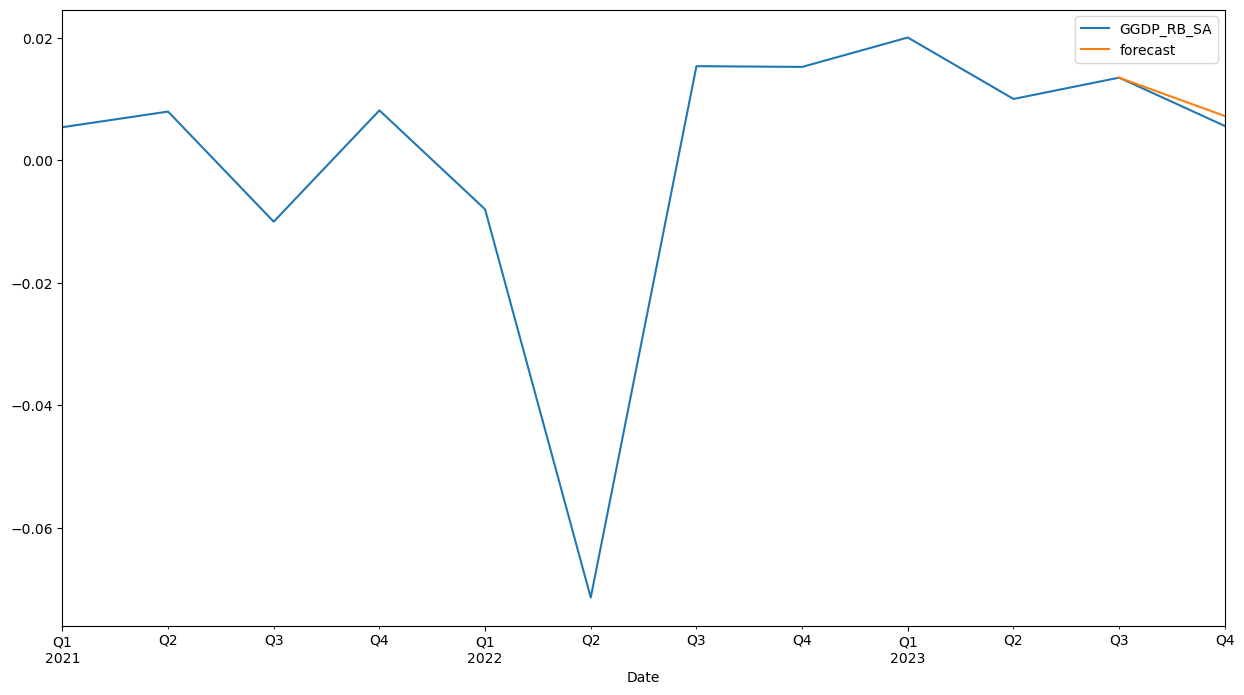

In [265]:
y, yl, x1, x2, yf, ylf, x1f, x2f = mix_freq2(lf_data=ggdp_rb_sa.GGDP_RB_SA['2016-07-01':], 
                                             hf_data1=log_growth_ex_rates.GRUB, 
                                             hf_data2=cpi_mm.CPI_MM['2016-07-01':], 
                                             x1lag=89, 
                                             x2lag=2, 
                                             ylag=1, 
                                             horizon=1,
                                             start_date=datetime.datetime(2016,7,1),
                                             end_date=datetime.datetime(2023,7,1))
model_1 = estimate2(y, yl, x1, x2, poly1='beta', poly2='beta')

fc1 = forecast2(x1,
               x2, 
               yl, 
               model_1, 
               poly1='beta',
               poly2='beta')
forecast1_df = fc1.join(ggdp_rb_sa.GGDP_RB_SA.loc['2016-11-01':'2023-07-01'])
forecast1_df['residuals'] = forecast1_df.yfh - forecast1_df.GGDP_RB_SA

models_predictions_statistics.loc['MIDAS CPI_MM+RUB Beta'] = [
    mean_absolute_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']),
    mean_absolute_percentage_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']),
    np.sqrt(mean_squared_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']))]

models_results = pd.concat([models_results, forecast1_df.yfh.loc['2020-07-01':'2023-07-01']], axis=1).rename(columns={'yfh' : 'MIDAS CPI_MM+RUB beta'})

models_results.plot(figsize=(15,8), style=['-', '-'])

fc = forecast2(x1f, x2f, ylf, model_1, poly1='beta',poly2='beta')
forecast_df = fc.join(yf)
forecast_df['residuals'] = forecast_df.yfh - forecast_df.GGDP_RB_SA

forecasting = ggdp_rb_sa.tail(2).head(1)
forecasting = forecasting.join(forecast_df.yfh, how='outer')
forecasting.iloc[0, 1] = forecasting.iloc[0, 0]
forecasting=forecasting.drop(columns=['GGDP_RB_SA']).rename(columns={'yfh':'forecast'})

models_forecast_statistics.loc['MIDAS CPI_MM+RUB Beta'] = [
    mean_absolute_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh),
    mean_absolute_percentage_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh),
    np.sqrt(mean_squared_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-07-01']], forecast_df.yfh))]

df_gdp = pd.concat([ggdp_rb_sa.GGDP_RB_SA['2021-01-01':'2023-10-01'], 
                    forecasting, ], axis=1)
df_gdp.plot(figsize=(15,8), style=['-', '-'])
None

C:\Users\bzzdwn\Documents\Mathematical-Modeling-And-Data-Analysis\Курсовая работа MIDAS\midas_realization\midas\weights.py:74: RuntimeWarning: overflow encountered in exp
  z = np.exp(self.theta1 * ilag + self.theta2 * ilag ** 2)
C:\Users\bzzdwn\Documents\Mathematical-Modeling-And-Data-Analysis\Курсовая работа MIDAS\midas_realization\midas\weights.py:75: RuntimeWarning: invalid value encountered in divide
  return z / sum(z)


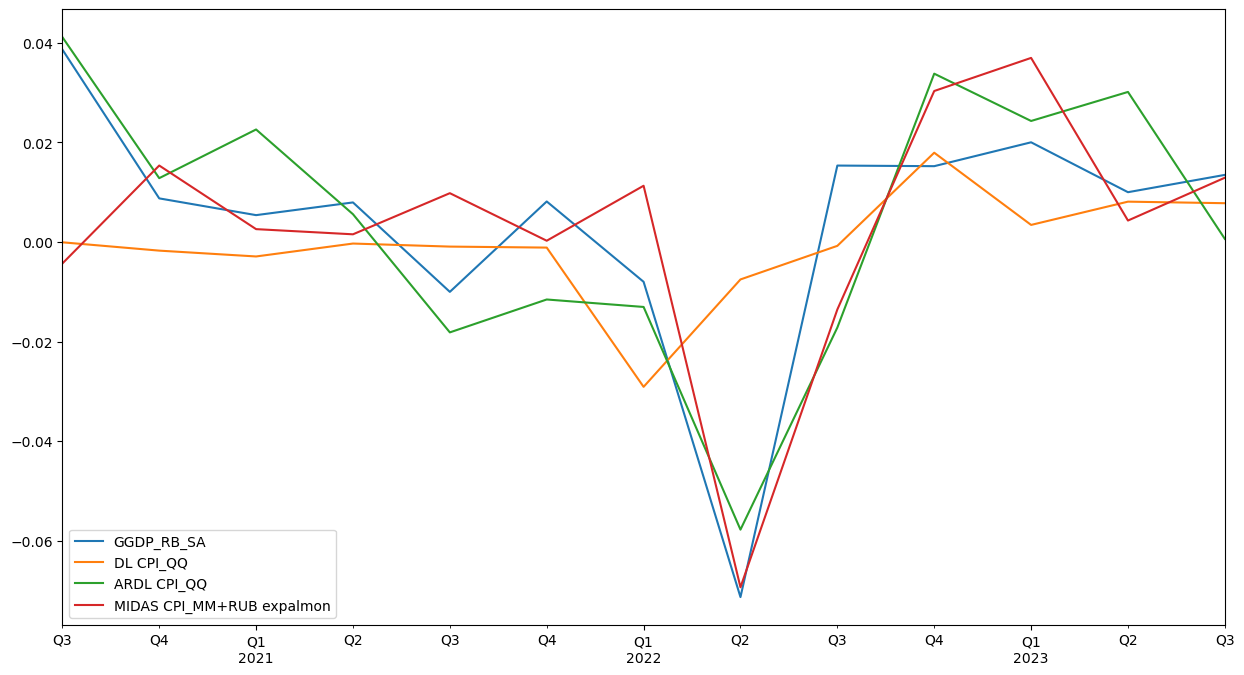

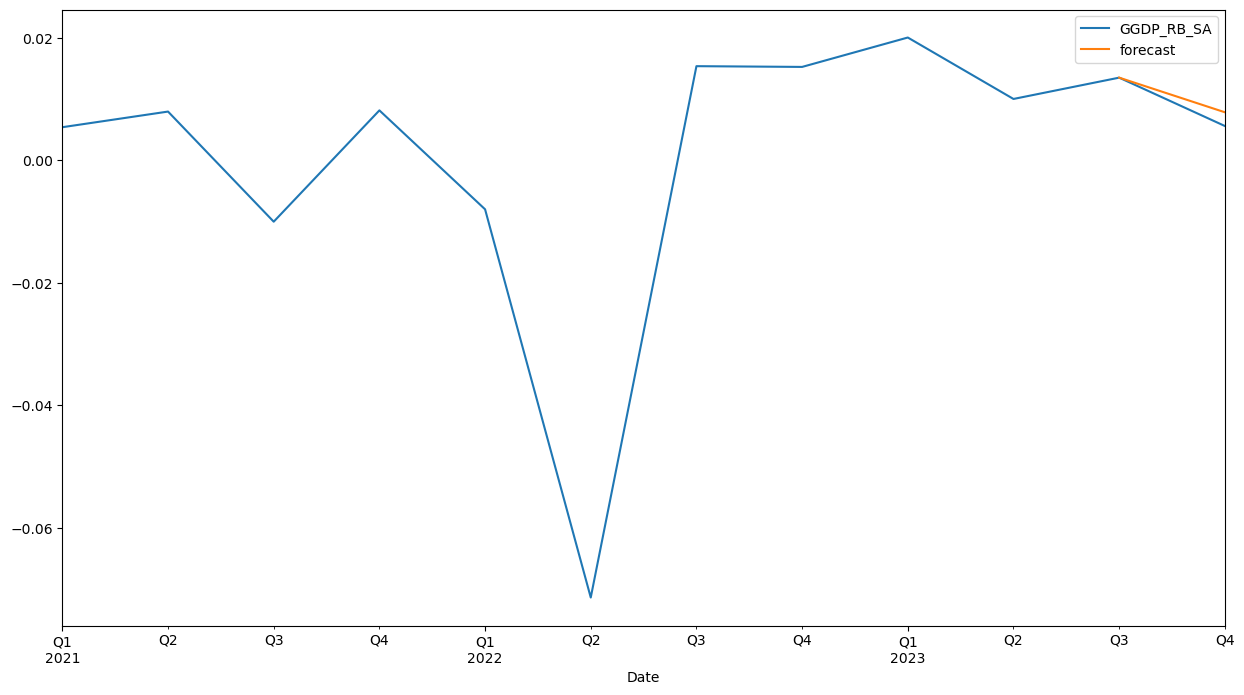

In [283]:
model_2 = estimate2(y, yl, x1, x2, poly1='expalmon', poly2='expalmon')

fc1 = forecast2(x1,
               x2, 
               yl, 
               model_2, 
               poly1='expalmon',
               poly2='expalmon')
forecast1_df = fc1.join(ggdp_rb_sa.GGDP_RB_SA.loc['2016-11-01':'2023-07-01'])
forecast1_df['residuals'] = forecast1_df.yfh - forecast1_df.GGDP_RB_SA

models_predictions_statistics.loc['MIDAS CPI_MM+RUB ExpAlmon'] = [
    mean_absolute_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']),
    mean_absolute_percentage_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']),
    np.sqrt(mean_squared_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']))]

models_results = pd.concat([models_results, forecast1_df.yfh.loc['2020-07-01':'2023-07-01']], axis=1).rename(columns={'yfh' : 'MIDAS CPI_MM+RUB expalmon'})

models_results.plot(figsize=(15,8), style=['-', '-'])

fc = forecast2(x1f, x2f, ylf, model_2, poly1='expalmon',poly2='expalmon')
forecast_df = fc.join(yf)
forecast_df['residuals'] = forecast_df.yfh - forecast_df.GGDP_RB_SA

forecasting = ggdp_rb_sa.tail(2).head(1)
forecasting = forecasting.join(forecast_df.yfh, how='outer')
forecasting.iloc[0, 1] = forecasting.iloc[0, 0]
forecasting=forecasting.drop(columns=['GGDP_RB_SA']).rename(columns={'yfh':'forecast'})

models_forecast_statistics.loc['MIDAS CPI_MM+RUB ExpAlmon'] = [
    mean_absolute_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh),
    mean_absolute_percentage_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh),
    np.sqrt(mean_squared_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-07-01']], forecast_df.yfh))]

df_gdp = pd.concat([ggdp_rb_sa.GGDP_RB_SA['2021-01-01':'2023-10-01'], 
                    forecasting, ], axis=1)
df_gdp.plot(figsize=(15,8), style=['-', '-'])
None

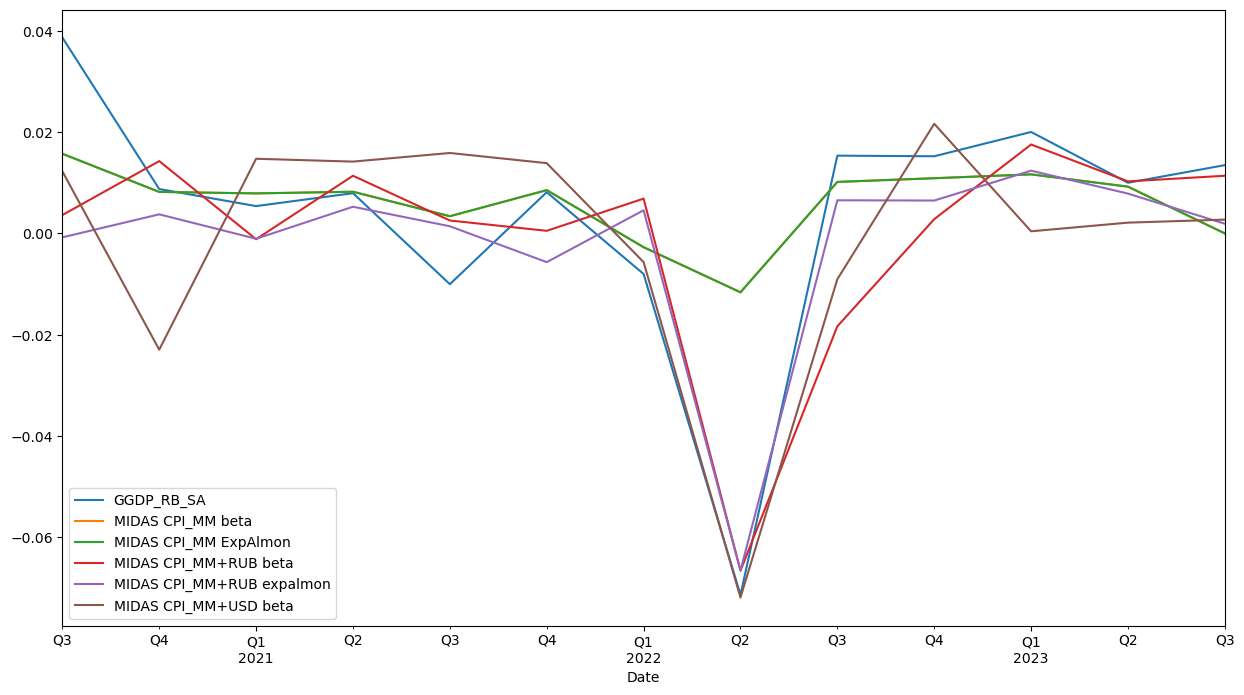

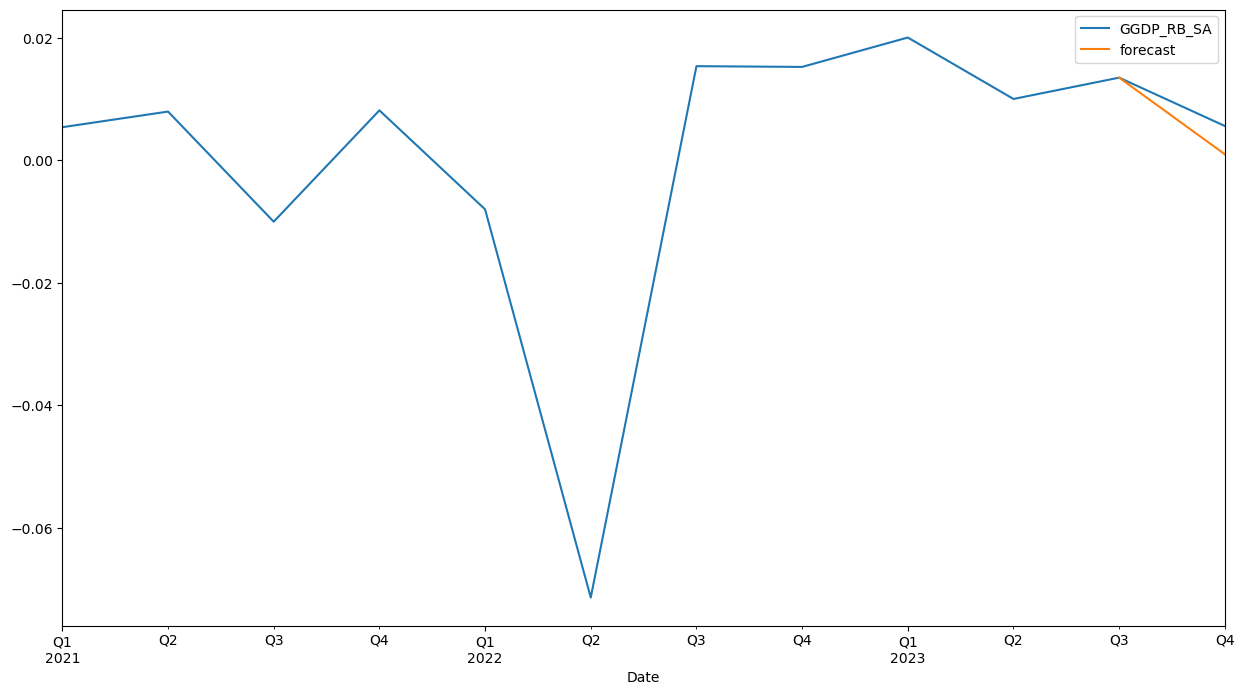

In [267]:
y, yl, x1, x2, yf, ylf, x1f, x2f = mix_freq2(lf_data=ggdp_rb_sa.GGDP_RB_SA['2016-07-01':], 
                                             hf_data1=log_growth_ex_rates.GUSD, 
                                             hf_data2=cpi_mm.CPI_MM['2016-07-01':], 
                                             x1lag=89, 
                                             x2lag=2, 
                                             ylag=1, 
                                             horizon=1,
                                             start_date=datetime.datetime(2016,7,1),
                                             end_date=datetime.datetime(2023,7,1))
model_3 = estimate2(y, yl, x1, x2, poly1='beta', poly2='beta')

fc1 = forecast2(x1,
               x2, 
               yl, 
               model_3, 
               poly1='beta',
               poly2='beta')
forecast1_df = fc1.join(ggdp_rb_sa.GGDP_RB_SA.loc['2016-11-01':'2023-07-01'])
forecast1_df['residuals'] = forecast1_df.yfh - forecast1_df.GGDP_RB_SA

models_predictions_statistics.loc['MIDAS CPI_MM+USD Beta'] = [
    mean_absolute_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']),
    mean_absolute_percentage_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']),
    np.sqrt(mean_squared_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']))]

models_results = pd.concat([models_results, forecast1_df.yfh.loc['2020-07-01':'2023-07-01']], axis=1).rename(columns={'yfh' : 'MIDAS CPI_MM+USD beta'})

models_results.plot(figsize=(15,8), style=['-', '-'])

fc = forecast2(x1f, x2f, ylf, model_3, poly1='beta',poly2='beta')
forecast_df = fc.join(yf)
forecast_df['residuals'] = forecast_df.yfh - forecast_df.GGDP_RB_SA

forecasting = ggdp_rb_sa.tail(2).head(1)
forecasting = forecasting.join(forecast_df.yfh, how='outer')
forecasting.iloc[0, 1] = forecasting.iloc[0, 0]
forecasting=forecasting.drop(columns=['GGDP_RB_SA']).rename(columns={'yfh':'forecast'})

models_forecast_statistics.loc['MIDAS CPI_MM+USD Beta'] = [
    mean_absolute_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh),
    mean_absolute_percentage_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh),
    np.sqrt(mean_squared_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-07-01']], forecast_df.yfh))]

df_gdp = pd.concat([ggdp_rb_sa.GGDP_RB_SA['2021-01-01':'2023-10-01'], 
                    forecasting, ], axis=1)
df_gdp.plot(figsize=(15,8), style=['-', '-'])
None

C:\Users\bzzdwn\Documents\Mathematical-Modeling-And-Data-Analysis\Курсовая работа MIDAS\midas_realization\midas\weights.py:74: RuntimeWarning: overflow encountered in exp
  z = np.exp(self.theta1 * ilag + self.theta2 * ilag ** 2)
C:\Users\bzzdwn\Documents\Mathematical-Modeling-And-Data-Analysis\Курсовая работа MIDAS\midas_realization\midas\weights.py:75: RuntimeWarning: invalid value encountered in divide
  return z / sum(z)


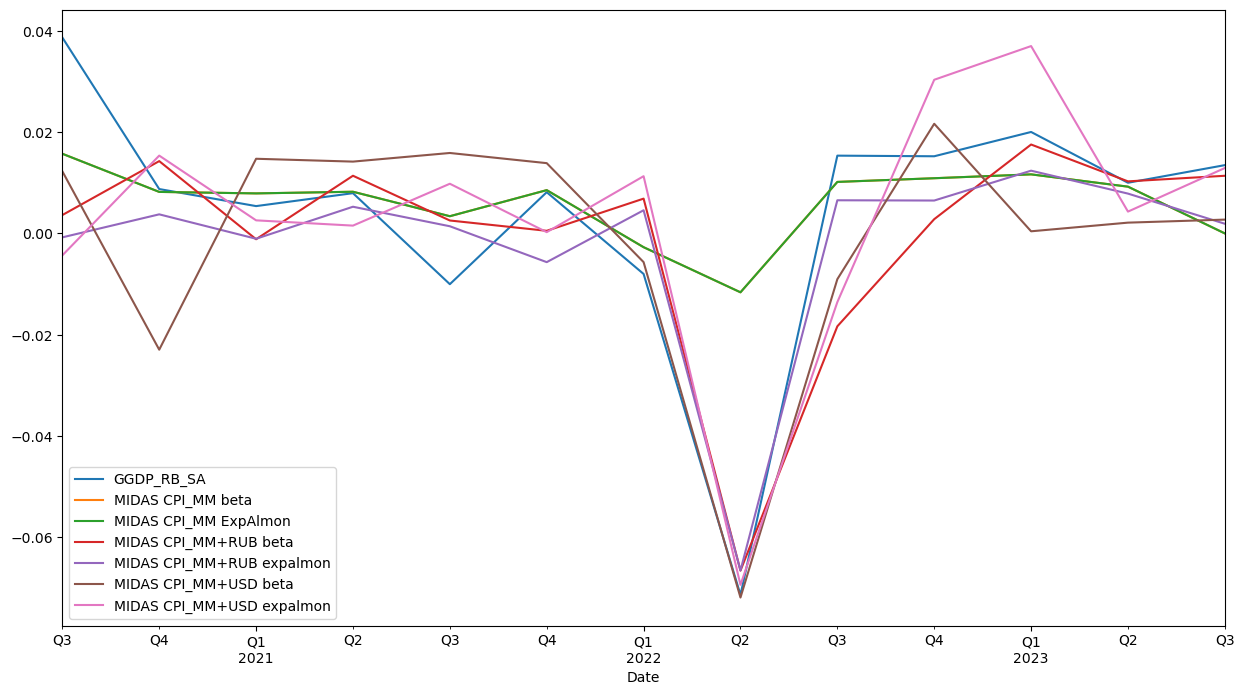

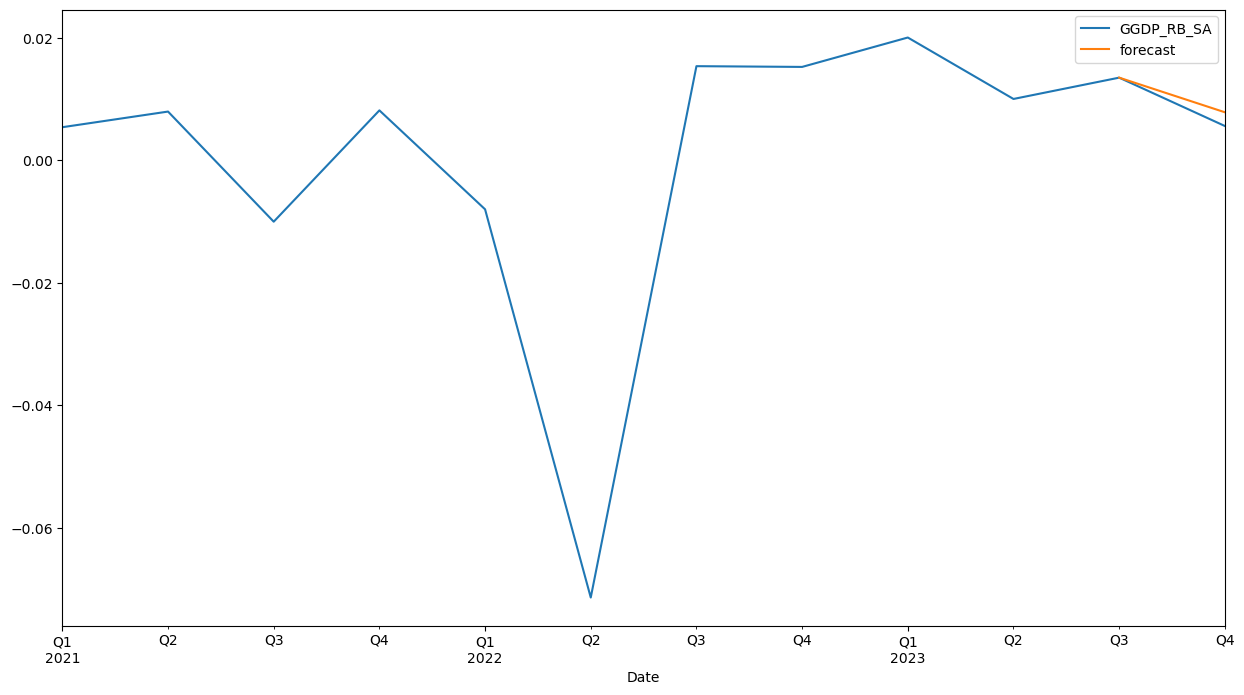

In [268]:
model_4 = estimate2(y, yl, x1, x2, poly1='expalmon', poly2='expalmon')

fc1 = forecast2(x1,
               x2, 
               yl, 
               model_4, 
               poly1='expalmon',
               poly2='expalmon')
forecast1_df = fc1.join(ggdp_rb_sa.GGDP_RB_SA.loc['2016-11-01':'2023-07-01'])
forecast1_df['residuals'] = forecast1_df.yfh - forecast1_df.GGDP_RB_SA

models_predictions_statistics.loc['MIDAS CPI_MM+USD ExpAlmon'] = [
    mean_absolute_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']),
    mean_absolute_percentage_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']),
    np.sqrt(mean_squared_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], forecast1_df.yfh.loc['2020-07-01':'2023-07-01']))]

models_results = pd.concat([models_results, forecast1_df.yfh.loc['2020-07-01':'2023-07-01']], axis=1).rename(columns={'yfh' : 'MIDAS CPI_MM+USD expalmon'})

models_results.plot(figsize=(15,8), style=['-', '-'])

fc = forecast2(x1f, x2f, ylf, model_4, poly1='expalmon',poly2='expalmon')
forecast_df = fc.join(yf)
forecast_df['residuals'] = forecast_df.yfh - forecast_df.GGDP_RB_SA

forecasting = ggdp_rb_sa.tail(2).head(1)
forecasting = forecasting.join(forecast_df.yfh, how='outer')
forecasting.iloc[0, 1] = forecasting.iloc[0, 0]
forecasting=forecasting.drop(columns=['GGDP_RB_SA']).rename(columns={'yfh':'forecast'})

models_forecast_statistics.loc['MIDAS CPI_MM+USD ExpAlmon'] = [
    mean_absolute_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh),
    mean_absolute_percentage_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-10-01']], forecast_df.yfh),
    np.sqrt(mean_squared_error([ggdp_rb_sa.GGDP_RB_SA.loc['2023-07-01']], forecast_df.yfh))]

df_gdp = pd.concat([ggdp_rb_sa.GGDP_RB_SA['2021-01-01':'2023-10-01'], 
                    forecasting, ], axis=1)
df_gdp.plot(figsize=(15,8), style=['-', '-'])
None

# DL

In [285]:
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n) 
    else:
        x = pd.Series(x)
        return x.shift(n) 

    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

In [286]:
#cpi_qq = cpi_mm.iloc[2::3]
#cpi_qq.index = gdp.index
#cpi_qq = cpi_qq[1:]
#plt.figure(figsize=(14, 8))
#plt.plot(cpi_mm)
#plt.plot(cpi_qq)
#None

In [287]:
lags = 1
endog = ggdp_rb_sa.GGDP_RB_SA['2015-01-01':'2023-07-01']
exog = cpi_qq.CPI_QQ['2015-01-01':'2023-07-01']

X = np.zeros((exog.shape[0], lags+1))
for i in range(lags + 1):
    X[:,i] = lag(exog, i).fillna(0)
X = sm.add_constant(X)
model = sm.OLS(endog.values, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.322
Date:                Fri, 17 May 2024   Prob (F-statistic):              0.281
Time:                        03:25:20   Log-Likelihood:                 75.595
No. Observations:                  35   AIC:                            -145.2
Df Residuals:                      32   BIC:                            -140.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4950      0.346      1.430      0.1

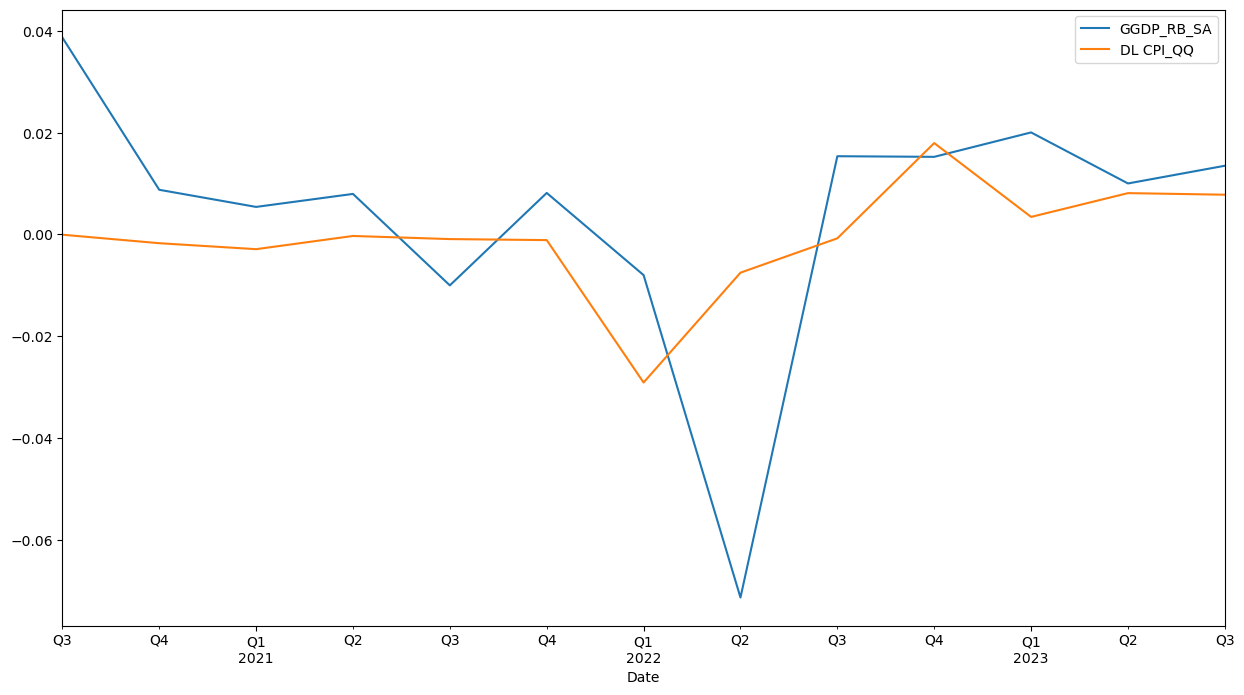

In [288]:
dl_predicts = model.predict(exog=pd.DataFrame(X).set_index(exog.index))
models_results = pd.DataFrame(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'])

models_predictions_statistics.loc['DL CPI_QQ'] = [
    mean_absolute_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], dl_predicts.loc['2020-07-01':'2023-07-01']),
    mean_absolute_percentage_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], dl_predicts.loc['2020-07-01':'2023-07-01']),
    np.sqrt(mean_squared_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], dl_predicts.loc['2020-07-01':'2023-07-01']))]

models_results = pd.concat([models_results, dl_predicts.loc['2020-07-01':'2023-07-01']], axis=1).rename(columns={0 : 'DL CPI_QQ'})
models_results.plot(figsize=(15,8), style=['-', '-'])
None

In [289]:
ardl = ardl_select_order(
    endog, 6, pd.DataFrame(exog), 6, ic="aic", trend="ct"
)
print(f"The optimal order is: {ardl.model.ardl_order}")
ardl_model = ardl.model.fit()
print(ardl_model.summary())

The optimal order is: (4, 1)
                              ARDL Model Results                              
Dep. Variable:             GGDP_RB_SA   No. Observations:                   35
Model:                     ARDL(4, 1)   Log Likelihood                  72.368
Method:               Conditional MLE   S.D. of innovations              0.023
Date:                Fri, 17 May 2024   AIC                           -126.736
Time:                        03:25:22   BIC                           -113.830
Sample:                    01-01-2016   HQIC                          -122.529
                         - 07-01-2023                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0016      0.411      2.439      0.023       0.152       1.851
trend            -0.0001      0.001     -0.255      0.801      -0.001       0.001
GGDP_RB_SA.

C:\Users\bzzdwn\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\bzzdwn\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


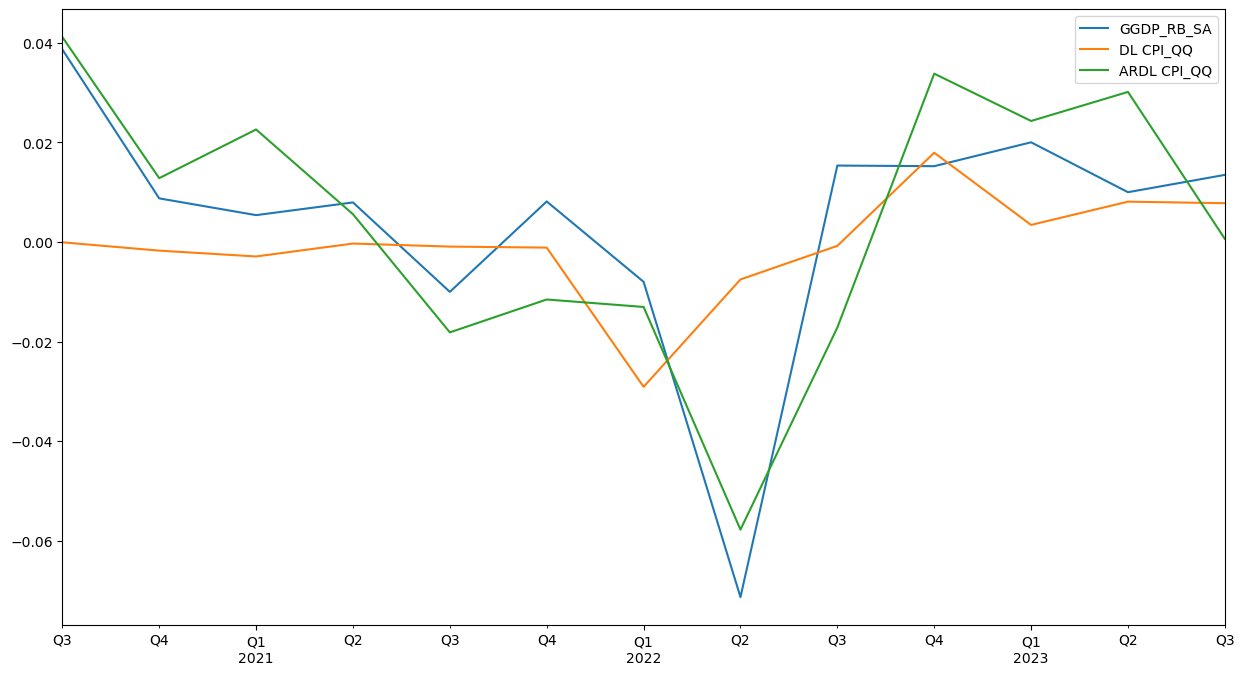

In [290]:
ardl_predicts = ardl_model.predict(exog=pd.DataFrame(exog))

models_predictions_statistics.loc['ARDL CPI_QQ'] = [
    mean_absolute_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], ardl_predicts.loc['2020-07-01':'2023-07-01']),
    mean_absolute_percentage_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], ardl_predicts.loc['2020-07-01':'2023-07-01']),
    np.sqrt(mean_squared_error(ggdp_rb_sa.GGDP_RB_SA.loc['2020-07-01':'2023-07-01'], ardl_predicts.loc['2020-07-01':'2023-07-01']))]

models_results = pd.concat([models_results, ardl_predicts.loc['2020-07-01':'2023-07-01']], axis=1).rename(columns={0 : 'ARDL CPI_QQ'})
models_results.plot(figsize=(15,8), style=['-', '-'])
None

# Дополнительно

In [46]:
DUM2020q1 = pd.DataFrame([0 for _ in range(ggdp_rb_sa.shape[0])], columns=['dum2020q1'], index=ggdp_rb_sa.index)
DUM2020q1.loc['2020-04-01'] = 1
DUM2020q1

,dum2020q1
Date,
2016-10-01,0
2017-01-01,0
2017-04-01,0
2017-07-01,0
2017-10-01,0
2018-01-01,0
2018-04-01,0
2018-07-01,0
2018-10-01,0


введение, приложение, заключение не нумеруется,

в конце 1 главы:
целью .... 

Заключение

1) ииследованы стат свойства временных рядов
2) построены ... модели
3) оценена точность прогнозов ретроспективных и будущих прогнозов для построенных моделей

качественные выводы 
... свойствами обладает модель


рассказать в связи с чем появились проблемы по агрегированным данным и по смешанным данным

1 слайд
титульный лист

2 слайд
цель и задачи работы сформулировать

3 слайд
модели ВР по смешанным данным

4-5 слайд 
базовая модель MIDAS

[для сранвния добавить модели по агрегированным данным, напр. ARDL]

построить АР по этим экзогенным переменным

посмотреть в статье как представляются результаты тестирования и сезонной корректировки

6 слайд
анализ точности прогнозов:
среди альтернативных моделей по смеш данным
лучшая по смешанным данным с лучшей по агрегированным данным

7 слайд
заключение
основными результатами работы являются...

8 слайд 
список используемых источников


In [33]:
DUM2020q1.to_csv('C:/Users/bzzdwn/Documents/Mathematical-Modeling-And-Data-Analysis/data/DUM2020q1.csv')

NameError: name 'DUM2020q1' is not defined

In [49]:
#df = pd.concat([cpi_sa, ex_rates[['usd_byn_stationary']]], axis=1)
DUM2022m03 = pd.DataFrame([0 for _ in range(cpi_mm.shape[0])], columns=['dum2022m03'], index=cpi_mm.index)
DUM2022m03.loc['2022-03-01'] = 1
DUM2022m03.to_csv('C:/Users/bzzdwn/Documents/Mathematical-Modeling-And-Data-Analysis/data/DUM2022m03.csv')
DUM2022m10m11 = pd.DataFrame([0 for _ in range(cpi_mm.shape[0])], columns=['dum2022m10m11'], index=cpi_mm.index)
DUM2022m10m11.loc['2022-10-01'] = 1
DUM2022m10m11.loc['2022-11-01'] = 1
DUM2022m10m11.to_csv('C:/Users/bzzdwn/Documents/Mathematical-Modeling-And-Data-Analysis/data/DUM2022m10m11.csv')
target = pd.concat([cpi_mm,  DUM2022m03, DUM2022m10m11], axis=1)

In [123]:
target

,CPI_MM,dum2022m03,dum2022m10m11
Date,,,
2016-07-01,100.7808,0,0
2016-08-01,100.5109,0,0
2016-09-01,100.5677,0,0
2016-10-01,100.6141,0,0
2016-11-01,100.8134,0,0
...,...,...,...
2023-08-01,100.3874,0,0
2023-09-01,100.5203,0,0
2023-10-01,100.5128,0,0


In [ ]:
min_rmse = 1e6
best_lags = []
for x1lags in [i for i in range(90)]:
    for x2lags in [i for i in range(5)]:
        y, yl, x1, x2, yf, ylf, x1f, x2f = mix_freq2(lf_data=gdp_rb_sa_d.RB_GDP_SA, 
                                             hf_data1=growth_ex_rates.RUB, 
                                             hf_data2=x13_analysis_ppi_rb.seasadj, 
                                             x1lag=x1lags, 
                                             x2lag=x2lags, 
                                             ylag=1, 
                                             horizon=1,
                                             start_date=datetime.datetime(2018,1,1),
                                             end_date=datetime.datetime(2022,10,1))
        model_1 = estimate2(y, yl, x1, x2, poly1='beta', poly2='beta')
    
        fc = forecast2(x1,
               x2, 
               yl, 
               model_1, 
               poly1='beta',
               poly2='beta')
        forecast_df = fc.join(gdp_rb_sa_d.RB_GDP_SA.loc['2018-07-01':'2022-11-01'])
        forecast_df['residuals'] = forecast_df.yfh - forecast_df.RB_GDP_SA
        rmse = np.sqrt(mean_squared_error(gdp_rb_sa_d.RB_GDP_SA.loc['2018-07-01':'2022-11-01'], forecast_df.yfh))
        if min_rmse > rmse:
            min_rmse = rmse
            best_lags = [x1lags, x2lags]

print(min_rmse, best_lags)